<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics-of-camera" data-toc-modified-id="Basics-of-camera-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics of camera</a></span><ul class="toc-item"><li><span><a href="#Camera-coordinates" data-toc-modified-id="Camera-coordinates-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Camera coordinates</a></span></li><li><span><a href="#Projection-Matrices" data-toc-modified-id="Projection-Matrices-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Projection Matrices</a></span></li></ul></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-pointcloud" data-toc-modified-id="Visualizing-the-pointcloud-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualizing the pointcloud</a></span></li><li><span><a href="#Dataset-handler" data-toc-modified-id="Dataset-handler-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Dataset handler</a></span><ul class="toc-item"><li><span><a href="#Generators" data-toc-modified-id="Generators-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Generators</a></span></li></ul></li><li><span><a href="#Visualizing-the-dataset" data-toc-modified-id="Visualizing-the-dataset-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Visualizing the dataset</a></span></li></ul></li><li><span><a href="#Disparity" data-toc-modified-id="Disparity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Disparity</a></span></li><li><span><a href="#Depth-map-from-disparity" data-toc-modified-id="Depth-map-from-disparity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Depth map from disparity</a></span></li><li><span><a href="#Depth-from-pointclouds" data-toc-modified-id="Depth-from-pointclouds-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Depth from pointclouds</a></span></li><li><span><a href="#Comparing-the-depth" data-toc-modified-id="Comparing-the-depth-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Comparing the depth</a></span></li><li><span><a href="#Visualizing" data-toc-modified-id="Visualizing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualizing</a></span><ul class="toc-item"><li><span><a href="#Difference-between-color-channels" data-toc-modified-id="Difference-between-color-channels-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Difference between color channels</a></span></li></ul></li><li><span><a href="#SIFT-(Scale-Invariant-Feature-Transform)" data-toc-modified-id="SIFT-(Scale-Invariant-Feature-Transform)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SIFT (Scale Invariant Feature Transform)</a></span><ul class="toc-item"><li><span><a href="#HOG-(Histogram-of-Gradients)" data-toc-modified-id="HOG-(Histogram-of-Gradients)-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>HOG (Histogram of Gradients)</a></span></li></ul></li></ul></div>

In [90]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Basics of camera

## Camera coordinates

Right hand rule system
- x direction goes to the right (u for image shown in gray)
- y direction goes down (v for image)
- z direction goes outside from the camera

In this image the ($X_{c}$, $Y_{c}$ and $Z_{c}$) is the coordinate for a point in the environment (world coordinate system) which is observed by the camera coordinate system. This point is captured in the image (shown in gray) by the camera as a point (x,y).

<img src="images/image_coordinate.png" width=800 height=800 />

In [91]:
poses = pd.read_csv('dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
print(first_pose)

Shape of position dataframe: (4541, 12)
First position:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -0.]]


<IPython.core.display.Javascript object>


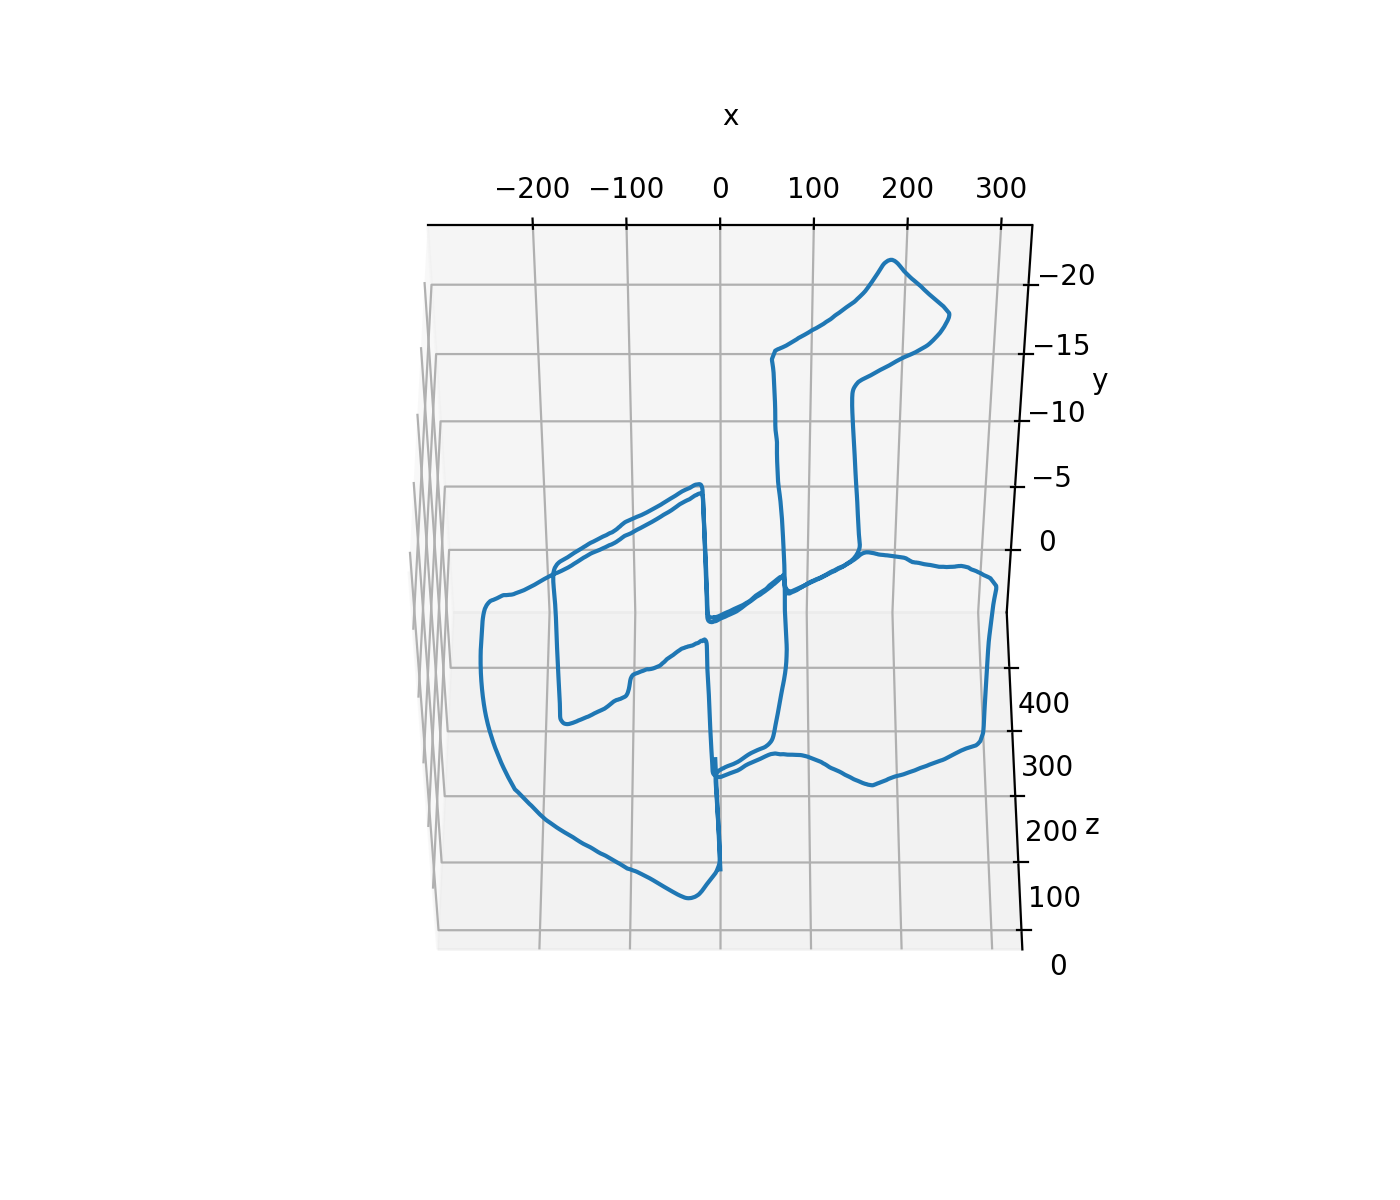

In [92]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
    
%matplotlib notebook
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

## Projection Matrices

These matrices contain intrinsic information about the camera's focal length and optical center. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame. A projection matrix (3*4) takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the formula present below.

<img src="images/projection_matrices1.png" width=800 height=800 />

NOTE: here $\tau$ is basically the depth of the object from the camera, so we lose the depth information and project everything in the 2d plane.

<img src="images/projection_matrices2.png" width=800 height=800 />

NOTE: intrinsic matrix $$ K = \begin{bmatrix} f_{x} & 0 & c_{x} \\ 0 & f_{y} & c_{y} \\ 0 & 0 & 1 \end{bmatrix}$$ where f are the focal point and c is the optical center of the image.

<img src="images/projection_matrices3.png" width=800 height=800 />

In [93]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [94]:
# Decomposing a projection matrix with OpenCV
# P = Intrinsic (R|T)
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


# Dataset

In [95]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

NOTE: use generator to process a sequence of images

In [96]:
file_path = "dataset/sequences/00/image_0/"
left_images = os.listdir(file_path)
print(" the number of images in this sequence is:", len(left_images))

 the number of images in this sequence is: 4541


<IPython.core.display.Javascript object>


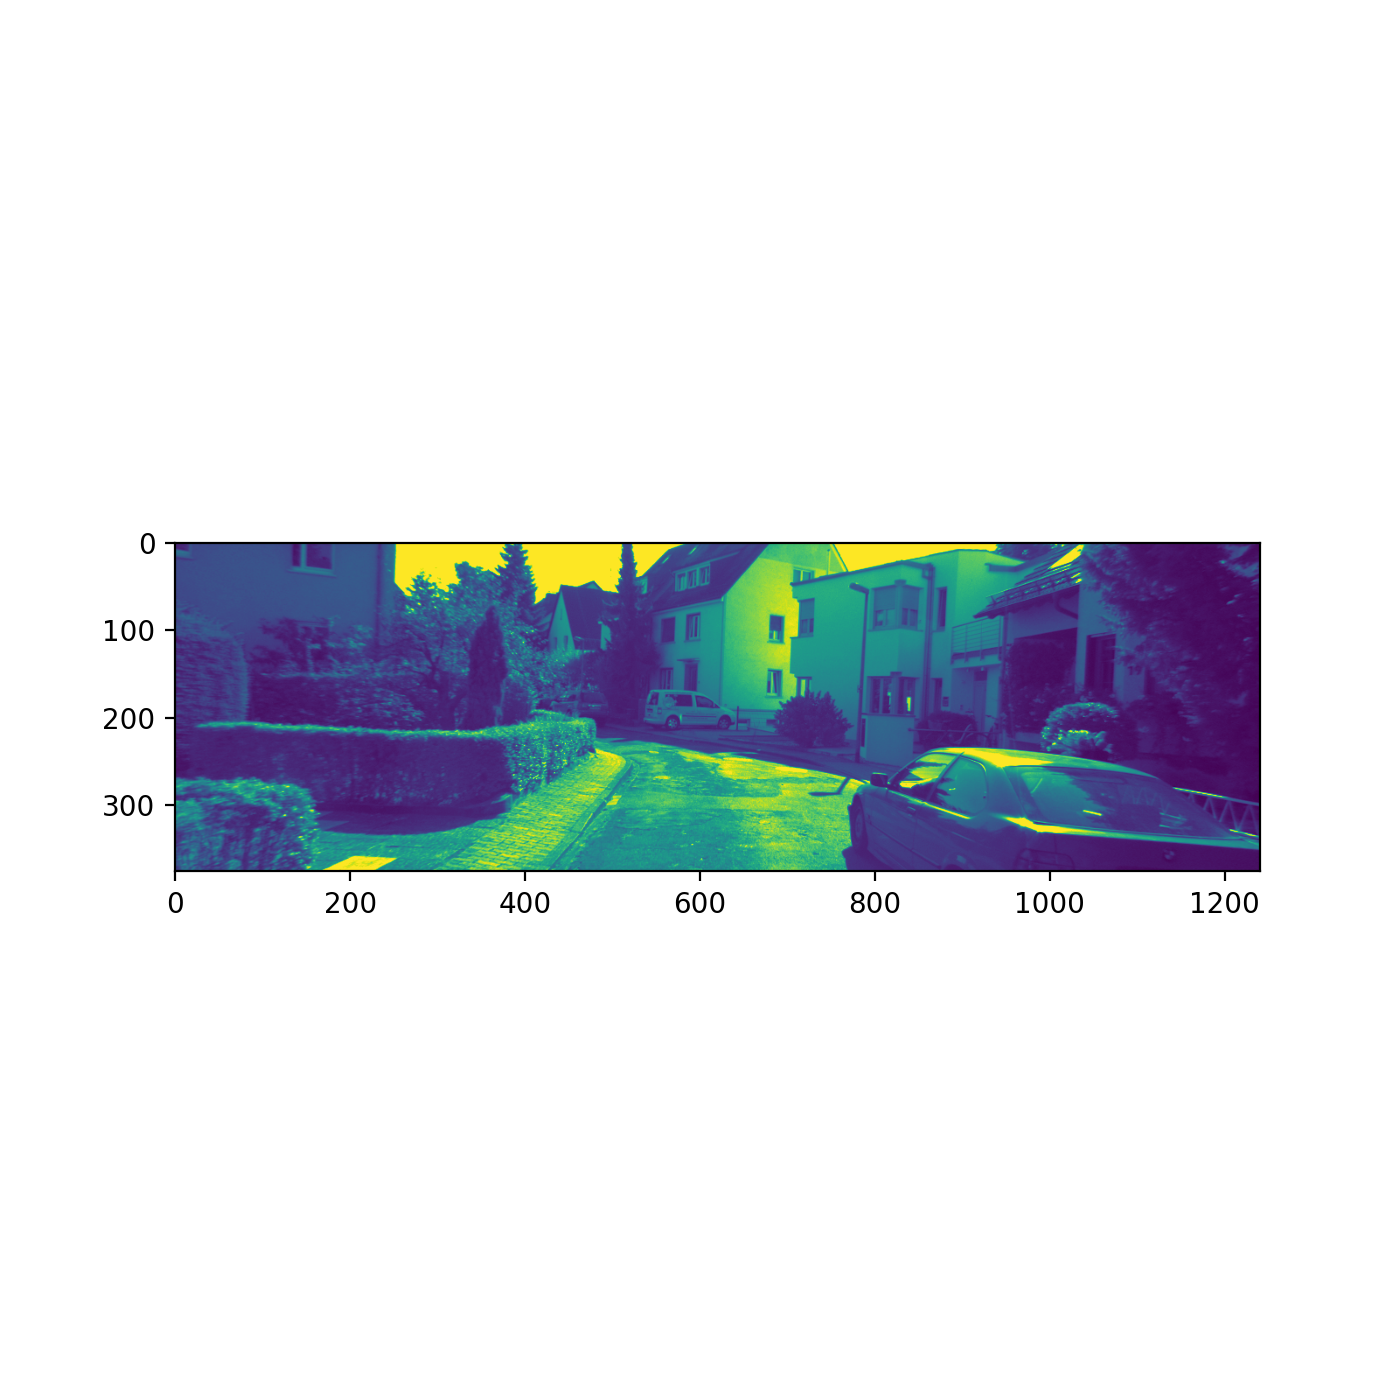

(376, 1241)

In [97]:
plt.figure(figsize=(7,7))
first_image = cv2.imread(file_path + left_images[0], 0)
plt.imshow(first_image)
first_image.shape

## Visualizing the pointcloud

In [98]:
file_path = "dataset/sequences/00/"
velodyne_file_path = os.listdir(file_path + "velodyne")
pointclouds = np.fromfile(file_path + "velodyne/" + velodyne_file_path[0], dtype=np.float32)
# reshaping it to x,y,z and one more value
pointclouds = pointclouds.reshape(-1,4)
pointclouds.shape

(112328, 4)

<IPython.core.display.Javascript object>


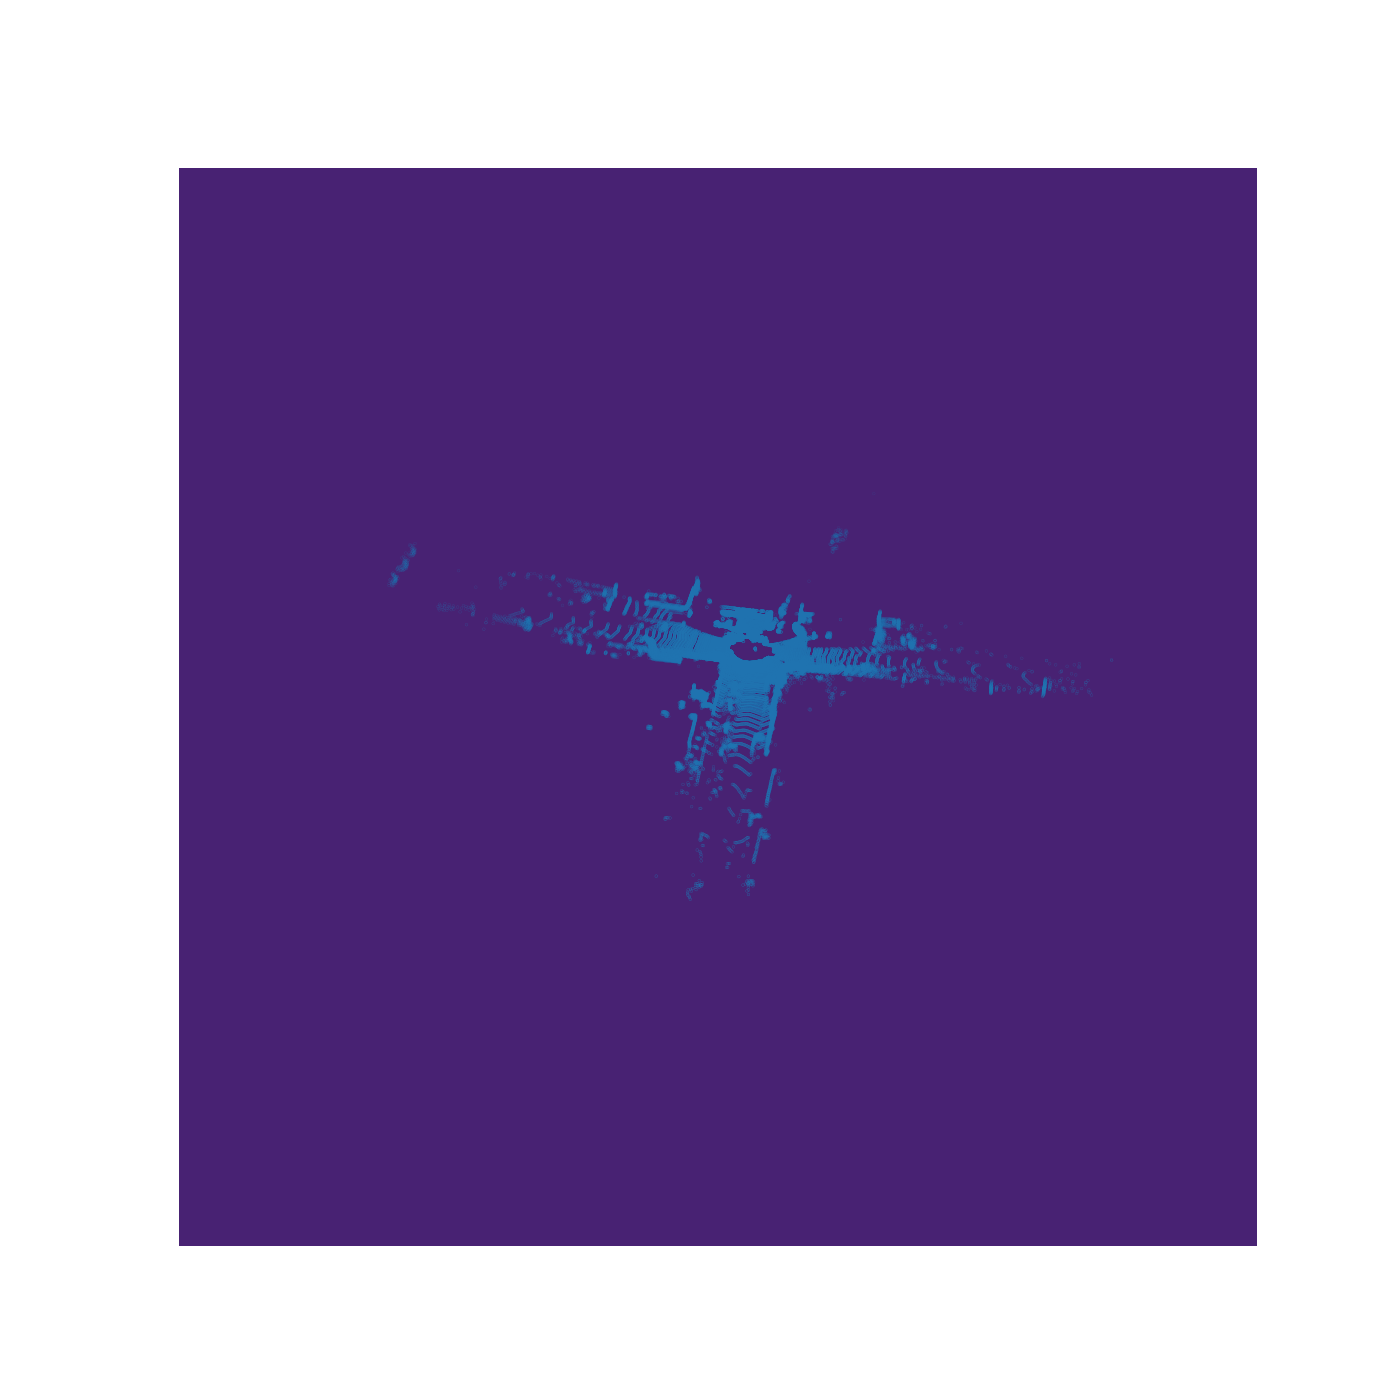

In [99]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,projection="3d")
x = pointclouds[:,0]
y = pointclouds[:,1]
z = pointclouds[:,2]
ax.set_box_aspect((np.ptp(x),np.ptp(y),np.ptp(z)))
ax.scatter(x,y,z,s=0.01)
ax.grid(False)
ax.axis("off")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=40, azim=100)

## Dataset handler

### Generators

Because the dataset is so bit and will require a lot of ram to load in the memory and store it, it s better to use generators which loads only one element of a sequence at a time. To use a generator use the list comprehension but instead of [ ] use ( ) and the next operator will have the next element and will not save the previous elements.

In [100]:
generators = (i for i in range(1,6))
next(generators)

1

In [200]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True):
        import pandas as pd
        import os
        import cv2
        
        #if handler contains lidar info
        self.lidar = lidar
        
        #file paths and ground truth poses
        self.seq_dir = 'dataset/sequences/{}/'.format(sequence)
        self.poses_dir = 'dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        #names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        
        self.left_image_files.sort()
        self.right_image_files.sort()
        self.velodyne_files.sort()
        
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        #calibration details for scene, P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        #times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', delimiter=' ', header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        #use generators
        self.reset_frames()
        
        #just for testing, store original frame to memory
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[1], 0)
        if self.lidar:
            self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                dtype=np.float32, 
                                                count=-1).reshape((-1, 4))
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

## Visualizing the dataset

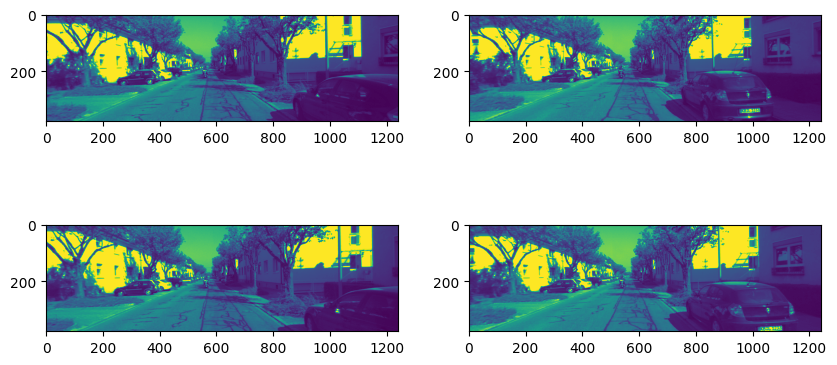

In [234]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(next(handler.images_left))
ax2.imshow(next(handler.images_right))
ax3.imshow(next(handler.images_left))
ax4.imshow(next(handler.images_right))

# Disparity

The disparity is the apparent motion of objects between a pair of stereo images. To experience this, try closing one eye and then rapidly open it while closing the other one. You will note that closer objects will move significantly while objects further away will move very little.

Given a pair of stereo images, to compute the disparity map, we first match every pixel in the left image with its corresponding pixel in the right image. Then we compute the distance for each pair of matching pixels. Finally, the disparity map is obtained by representing such distance values as an intensity image.

<img src="images/disparity.png" width=900 height=800 />


In [202]:
def compute_left_disparity_map(img_left, img_right, matcher='bm'):
    
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )

    disparity = matcher.compute(img_left, img_right).astype(np.float32)/16
    
    return disparity

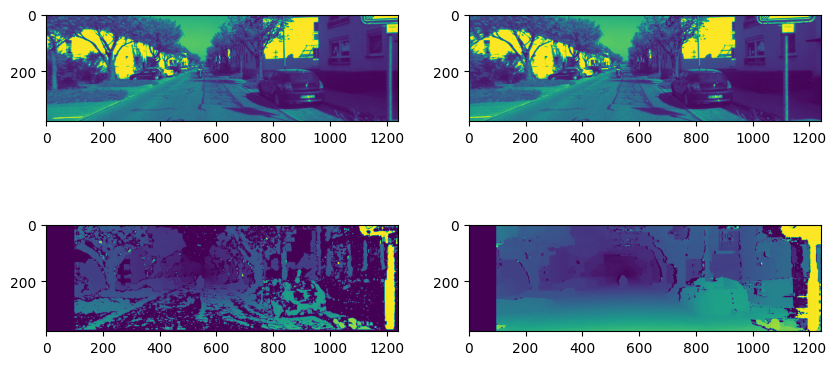

In [232]:
disparity_bm = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm')
disparity_sgbm = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm')
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(handler.first_image_left)
ax2.imshow(handler.first_image_right)
ax3.imshow(disparity_bm)
ax4.imshow(disparity_sgbm);

# Depth map from disparity

<img src="images/stereo_camera.png" width=500 height=500 />

using triangulation method, we get,

$$
  Z = \frac{f b}{d}
$$

$$
  d = x_L - x_R
$$

where, d is the disparity and $x_L$ and $x_R$ are difference in horizontal pixel location of the point projected onto the left and right image planes and b is the baseline.

openCV has 2 methods to calculate the disparity map:
1. bm
2. sgbm

sgbm performs better than bm but is comparitively slower

$$Z = \frac{f b}{d}$$

we will be using the above formula to calculate the depth image, here f is the f_x from the intrinsic matric, b is the baseline and d is the disparity map we get earlier

In [204]:
# to get parameters from the projection matrix
def decompose_projection_matrix(p):

    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [205]:
def calc_depth_map(disparity_map, k_left, t_left, t_right, rectified=True):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disparity_map[disparity_map == 0.0] = 0.1
    disparity_map[disparity_map == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disparity_map.shape)
    depth_map = f * b / disparity_map
    
    return depth_map

Now we will create a combined function that will calculate the disparity map and extract depth map from it. The steps are as follows:
1. calculate the disparity map between two left and right images
2. get the parameters f and b from the projection matrices
3. calculate the depth map by using the formula: 
$$Z = \frac{f b}{d}$$

In [206]:
# coding everything together
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rectified=True):
    
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [207]:
depth_map = stereo_2_depth(handler.first_image_left,
                      handler.first_image_right,
                      handler.P0,
                      handler.P1,
                      matcher="sgbm",
                      rectified="True")

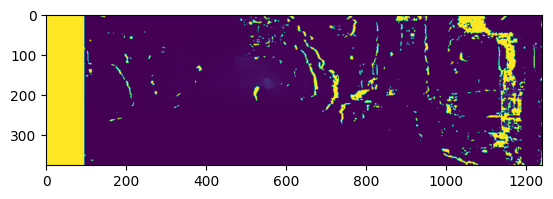

In [208]:
fig = plt.figure()
plt.imshow(depth_map);

In [209]:
print(depth_map.max())
depth_map[depth_map < 3000].max()

3861.447942459941


686.4796444444443

NOTE: here, the pixel value 3861 corresponds to the disparity value 0 and -1, which means this depth value is not useful to us. Hence, a filter can be applied to remove this value from processing.

# Depth from pointclouds

NOTE: although LIDAR is accurate but the pointcloud is sparse so we first found the depth from the stereo camera pairs

In [210]:
handler.first_pointcloud

array([[ 5.2897942e+01,  2.2989739e-02,  1.9979945e+00,  7.9999998e-02],
       [ 5.3750526e+01,  1.9291429e-01,  2.0269539e+00,  0.0000000e+00],
       [ 5.3803116e+01,  3.6183926e-01,  2.0289137e+00,  0.0000000e+00],
       ...,
       [ 3.8401384e+00, -1.4381756e+00, -1.7735560e+00,  3.4000000e-01],
       [ 3.8257158e+00, -1.4192016e+00, -1.7645701e+00,  2.5000000e-01],
       [ 4.0923753e+00, -1.5071962e+00, -1.8955611e+00,  0.0000000e+00]],
      dtype=float32)

In [211]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        render[v, u] = depth[j]
        
    return render

In [212]:
render = pointcloud2image(handler.first_pointcloud, 
                          handler.imheight,
                          handler.imwidth,
                          handler.Tr,
                          handler.P0
                         )

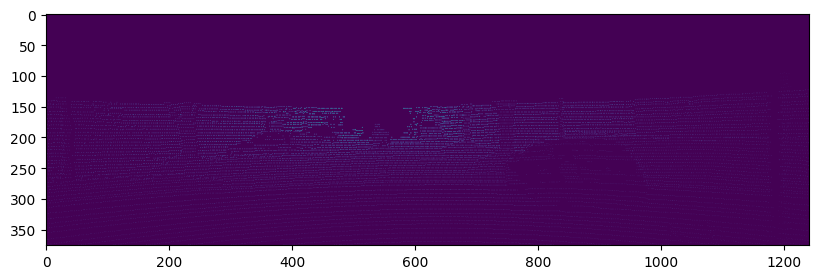

In [213]:
plt.figure(figsize=(10,3))
plt.imshow(render);

# Comparing the depth

comparing the depth values attained from the stereo camera and the pointclouds

In [215]:
counter = 0
for i in range(depth_map.shape[0]):
    for j in range(depth_map.shape[1]):
        if counter < 10:
            if render[i][j] > 0 and depth_map[i][j] != 3861.447942459941:
                print(depth_map[i][j], render[i][j])
                counter +=1

4.064682105263157 4.082927677078419
11.768222476190473 4.120294590980553
11.745849429657792 4.110687331964981
4.064682105263157 4.099315671169914
4.064682105263157 4.1157165271188605
11.701357575757573 4.124604063109464
11.701357575757573 4.099019064076344
4.064682105263157 4.092423873418519
4.064682105263157 4.098829136682579
4.064682105263157 4.090625286982059


In [216]:
handler.reset_frames
pcloud_frames = (pointcloud2image(next(handler.pointclouds),
                                  handler.imheight,
                                  handler.imwidth,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

In [217]:
for i in range(handler.num_frames // 50):
    cv2.imshow("lidar", next(pcloud_frames))
    cv2.waitKey(70)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread

# Visualizing

In [219]:
handler.reset_frames()
poses = (gt for gt in handler.gt)

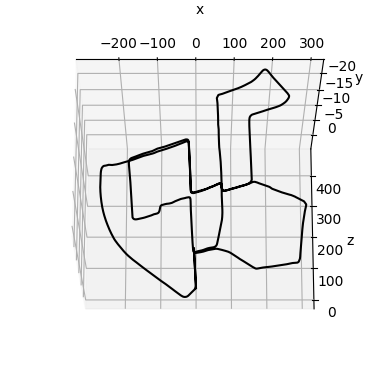

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread (0xf243a80).
Cannot move to target thread (0x1eb65b0)

QObject::moveToThread: Current thread (0x1eb65b0) is not the object's thread

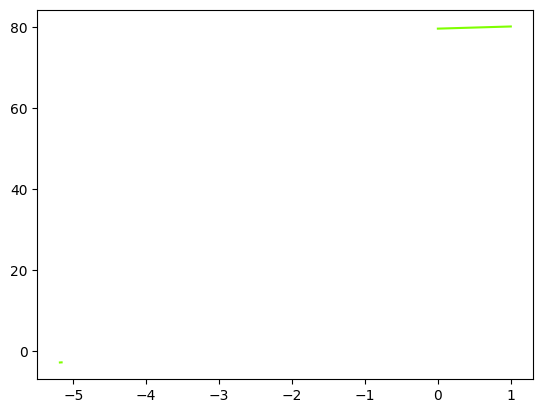

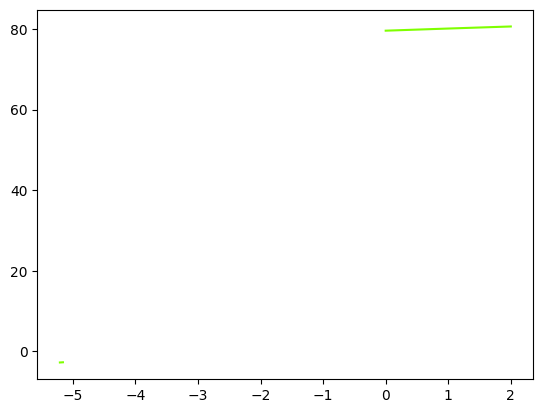

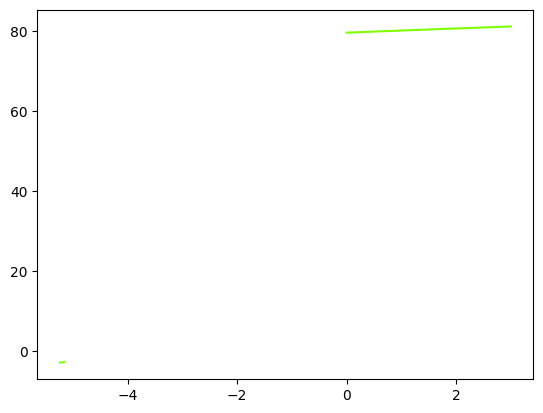

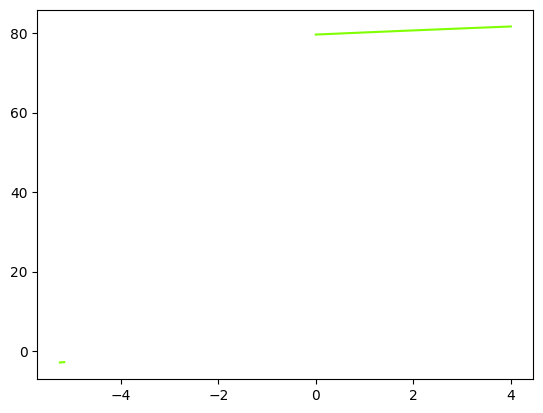

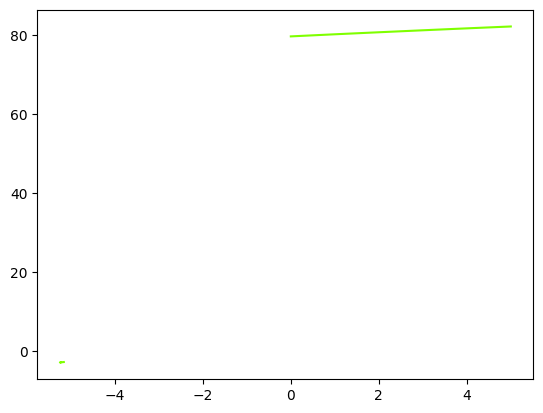

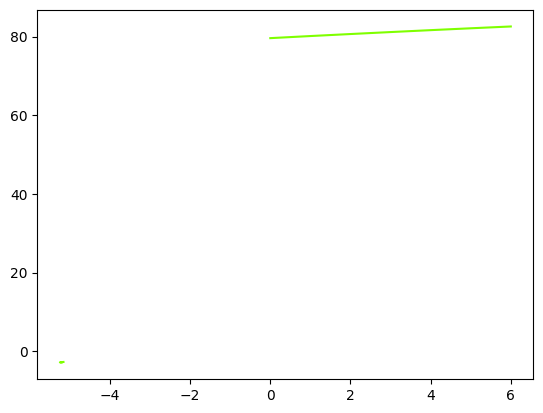

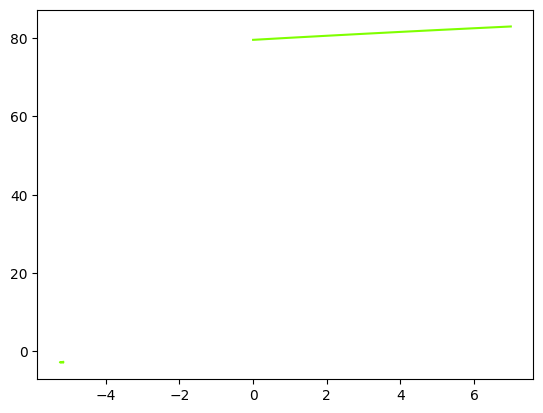

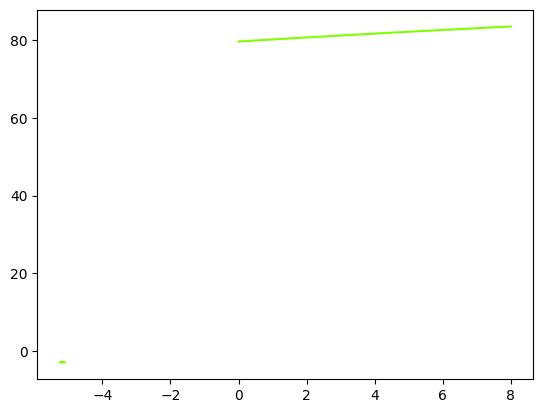

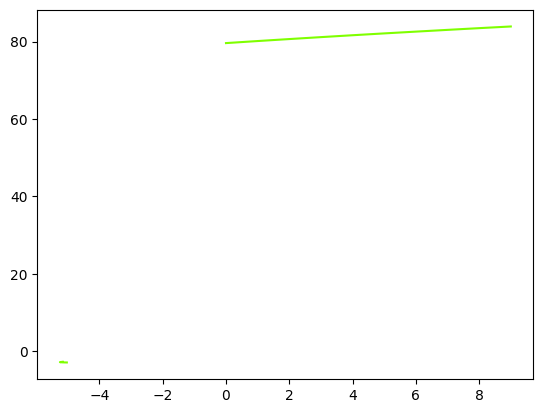

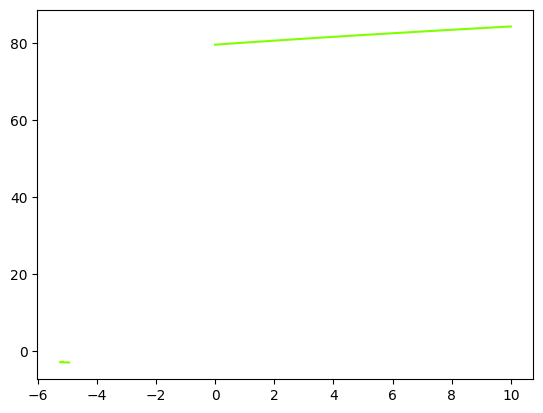

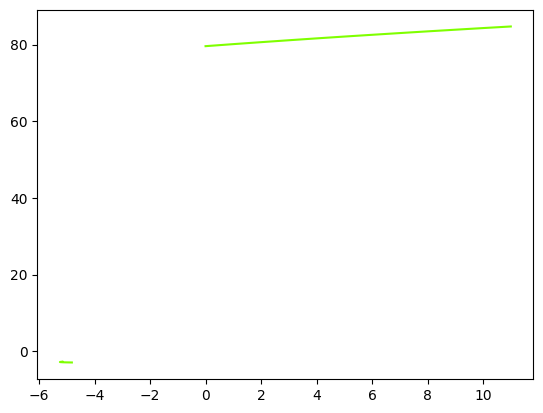

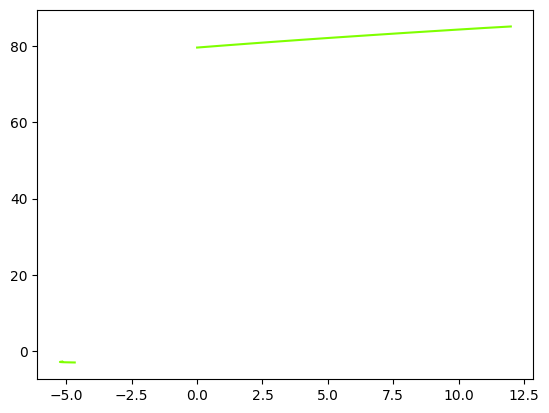

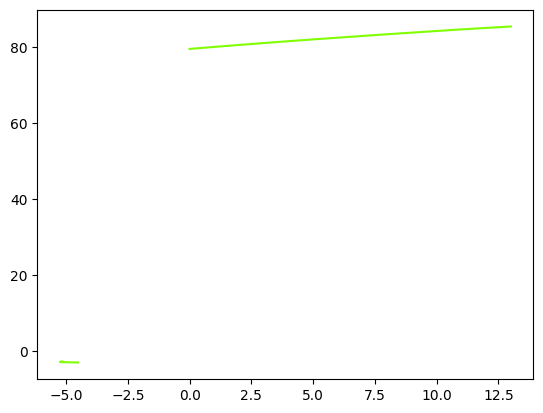

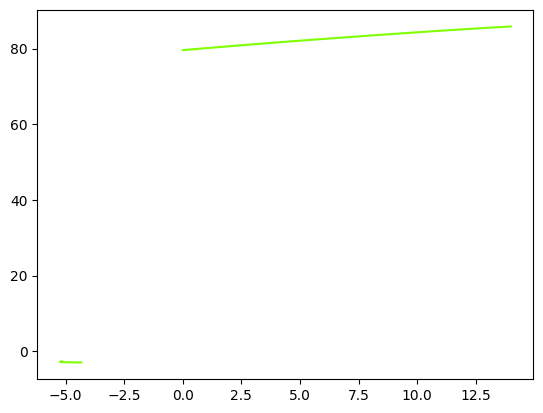

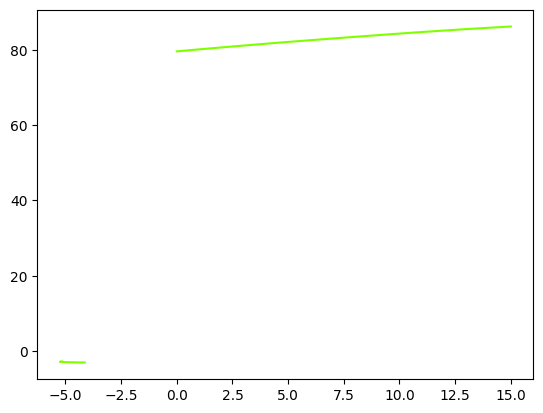

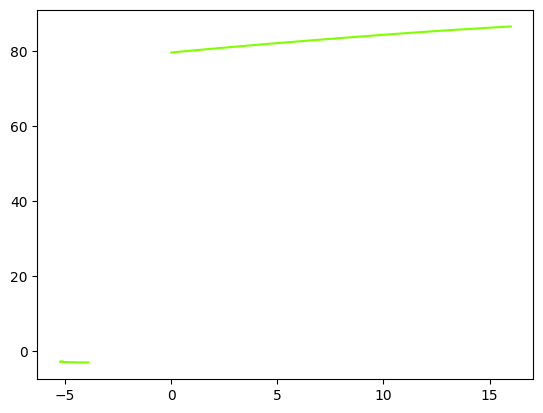

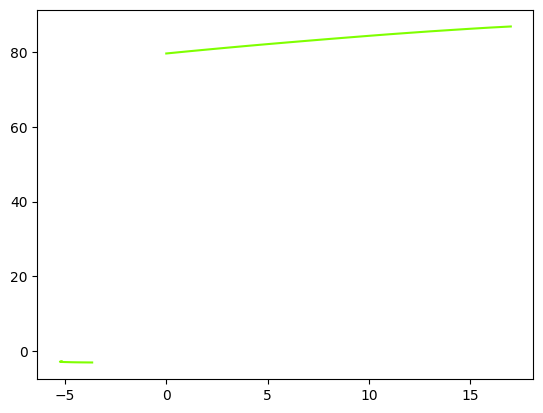

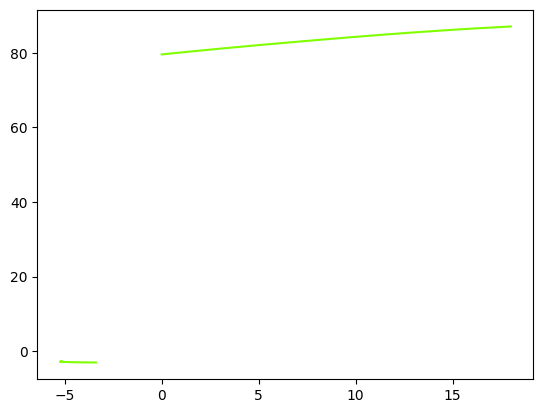

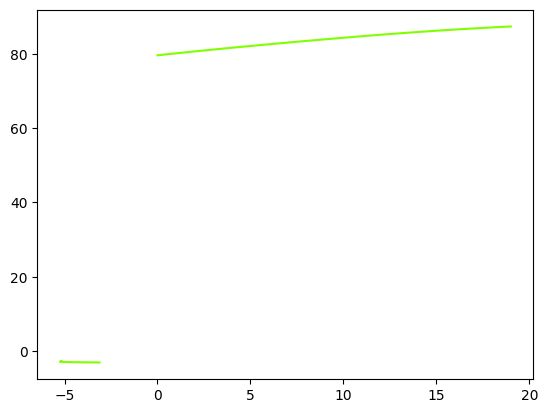

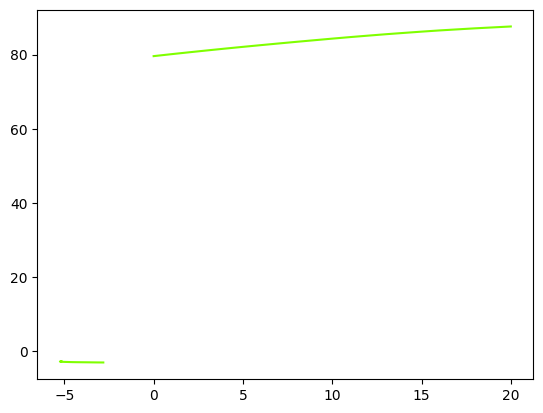

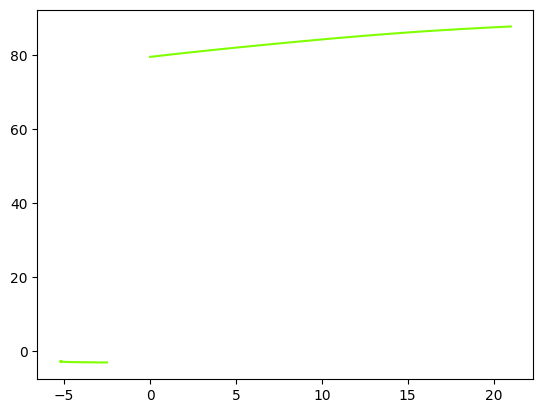

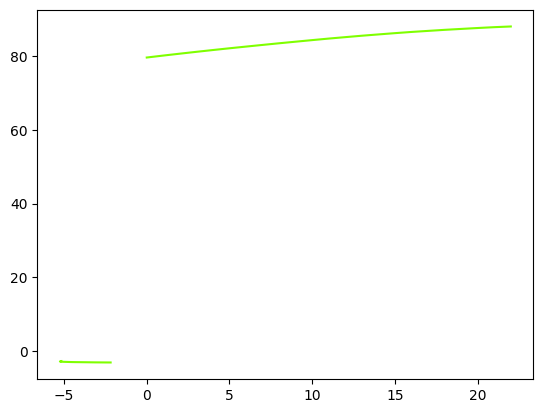

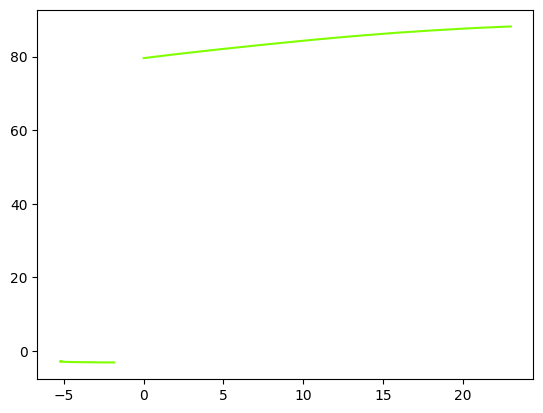

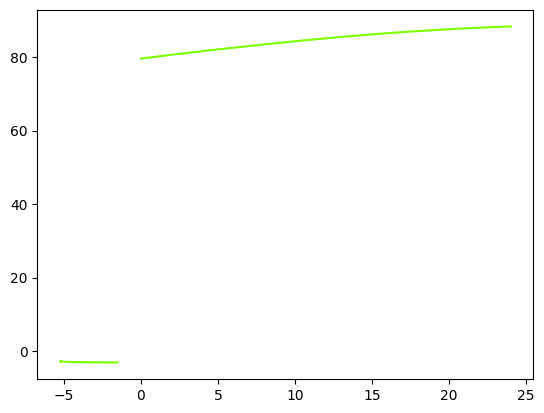

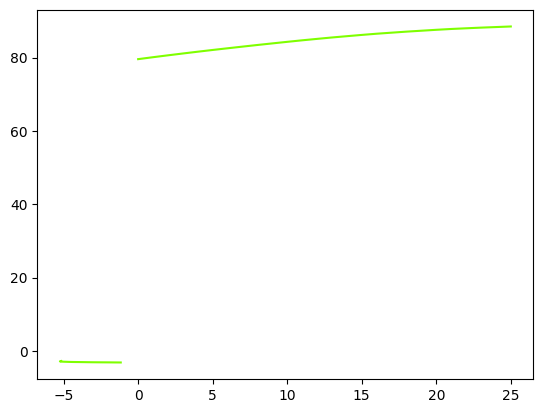

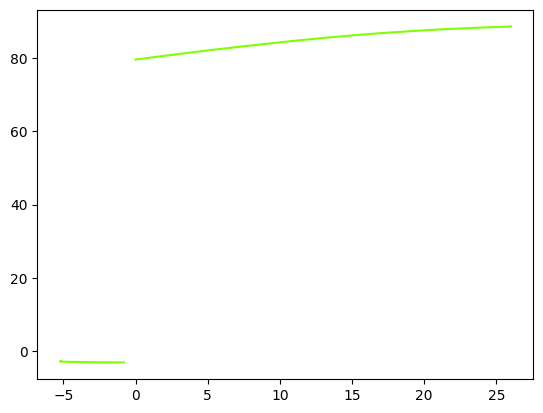

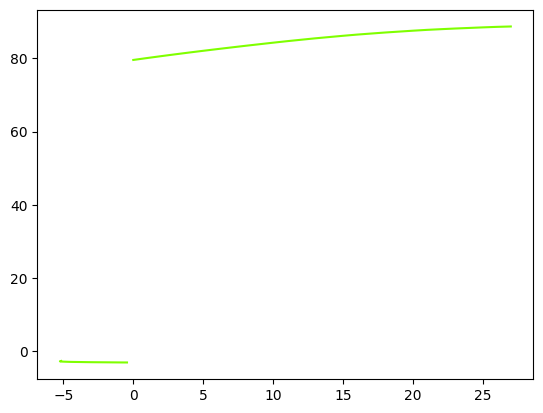

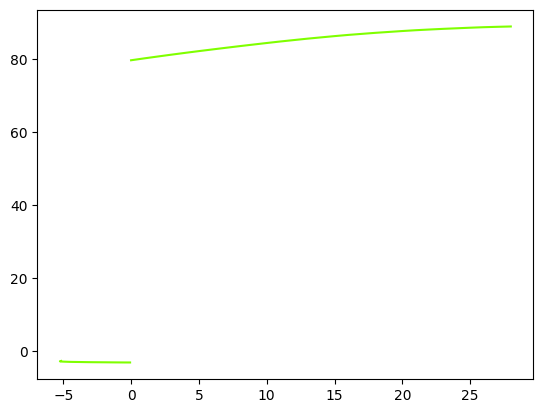

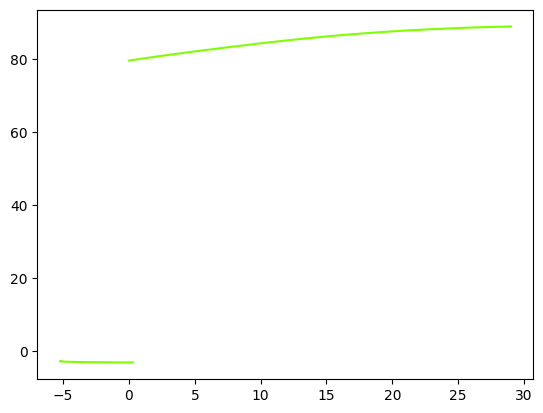

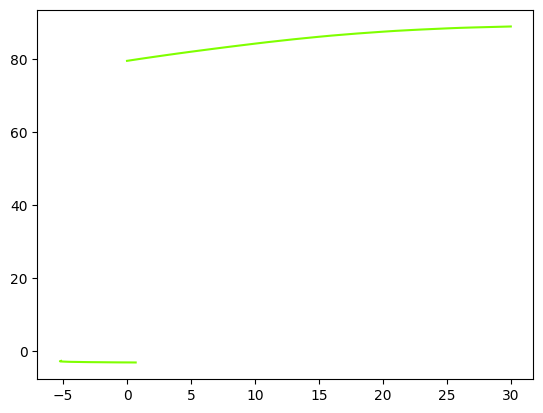

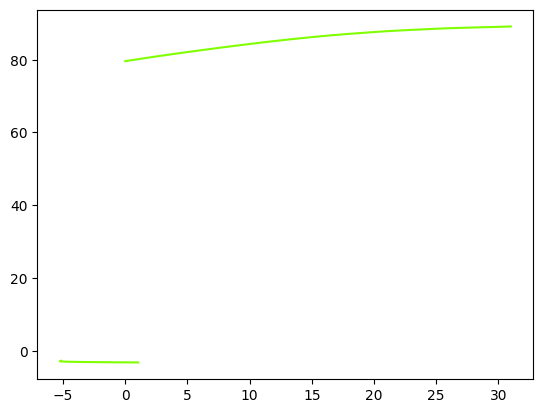

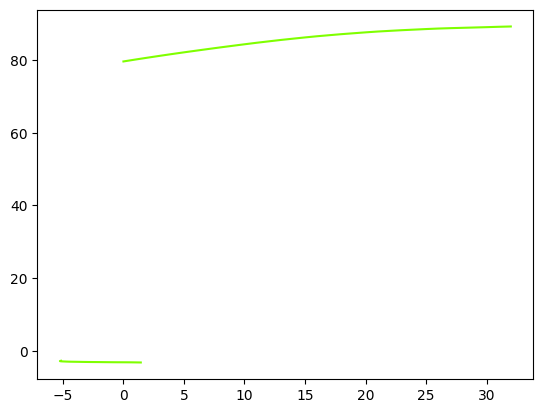

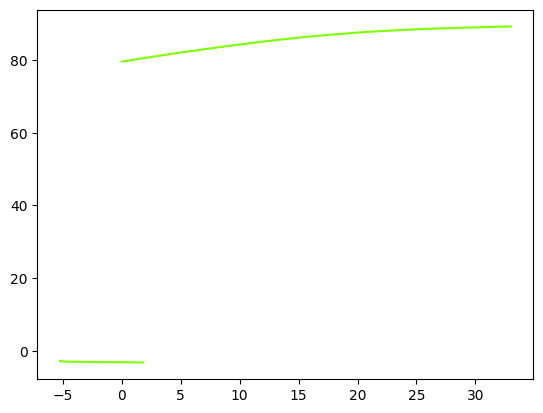

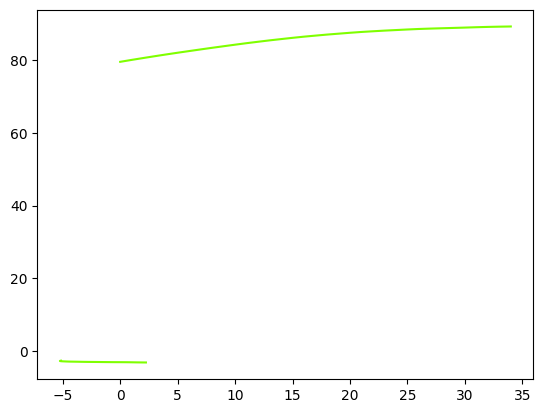

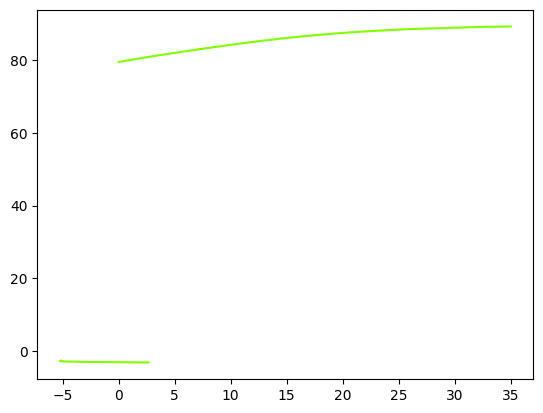

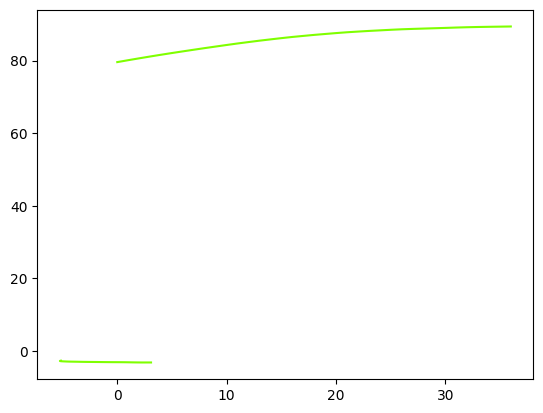

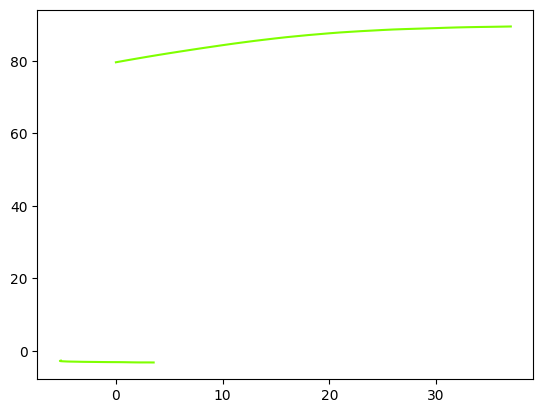

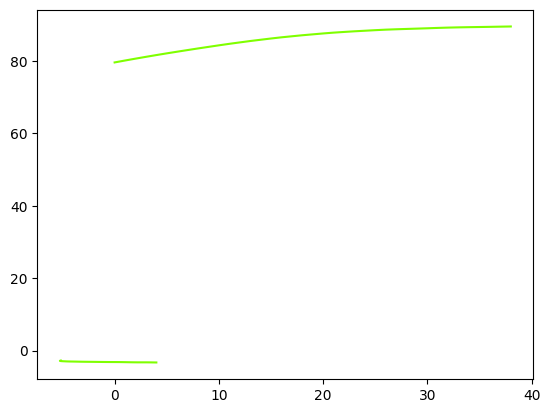

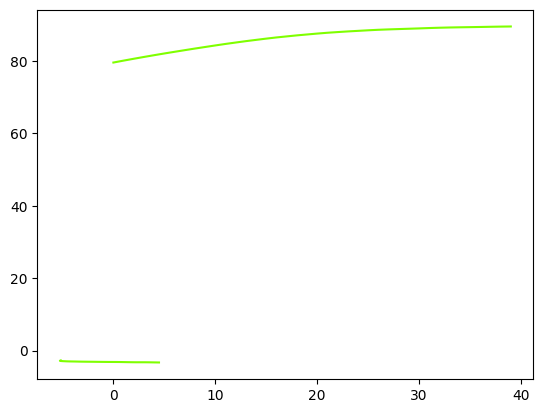

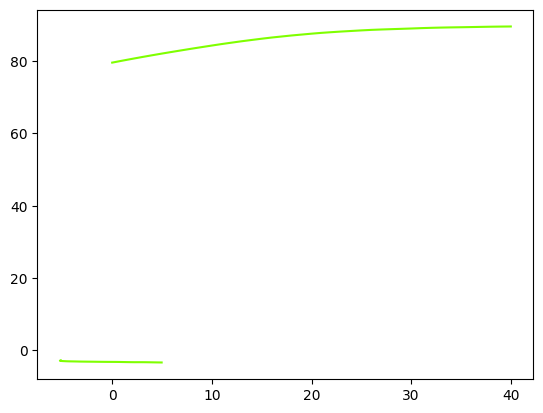

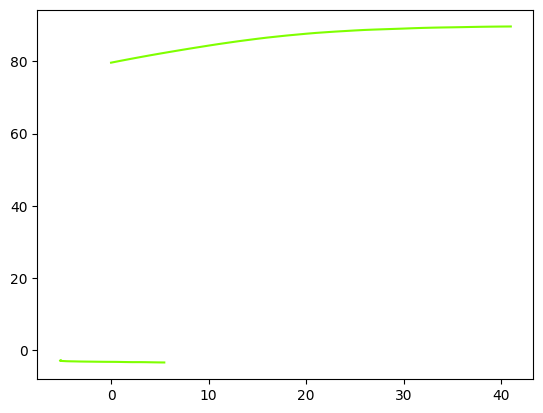

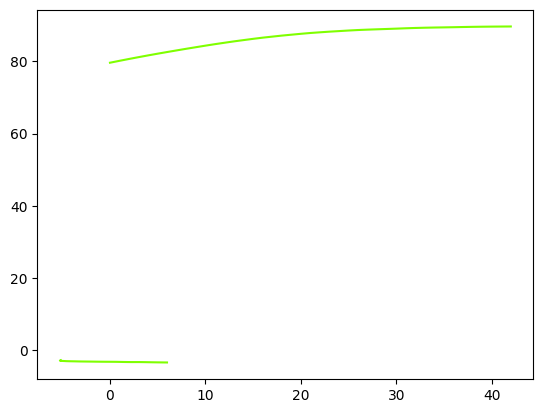

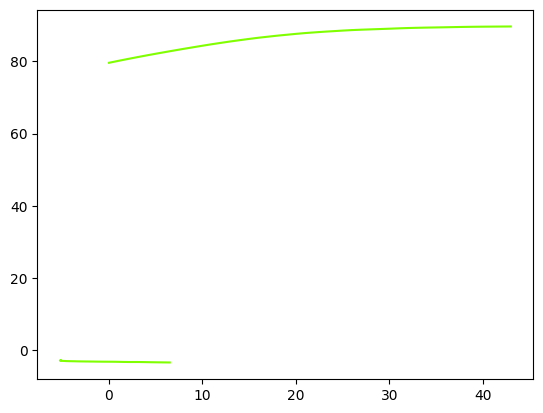

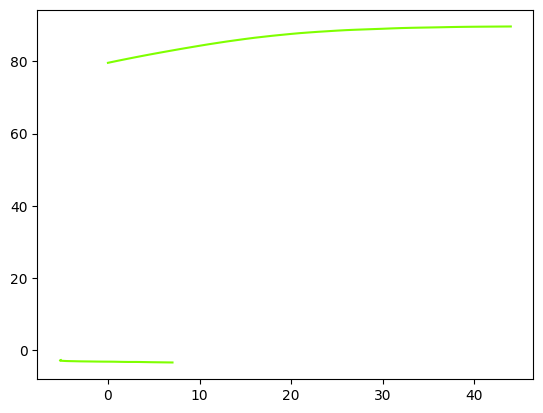

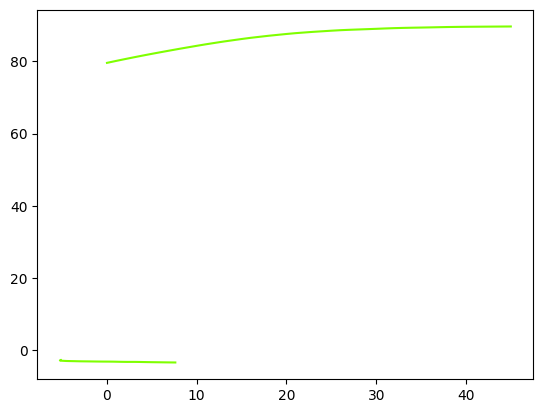

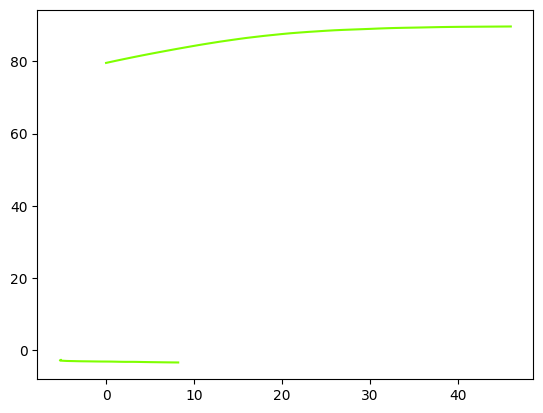

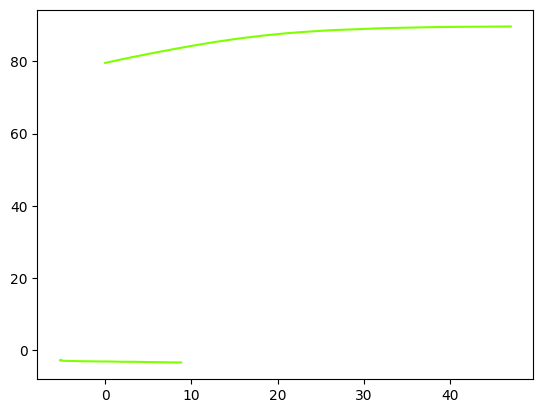

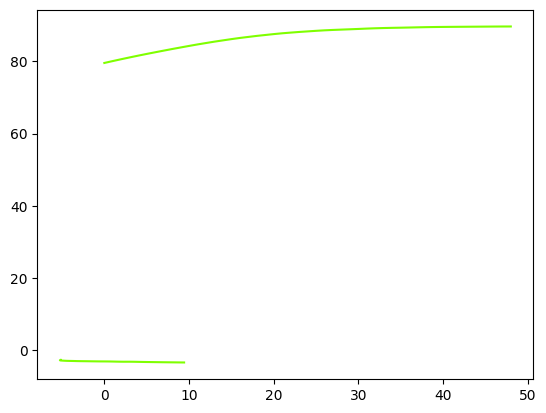

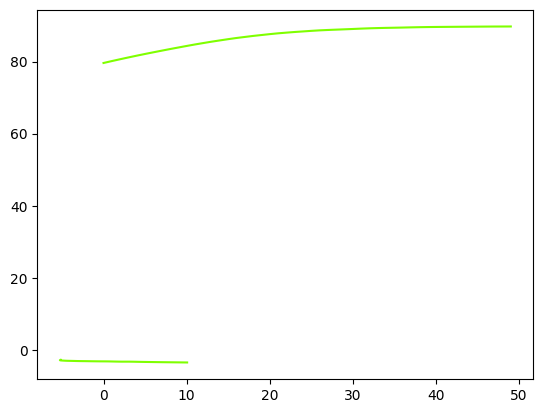

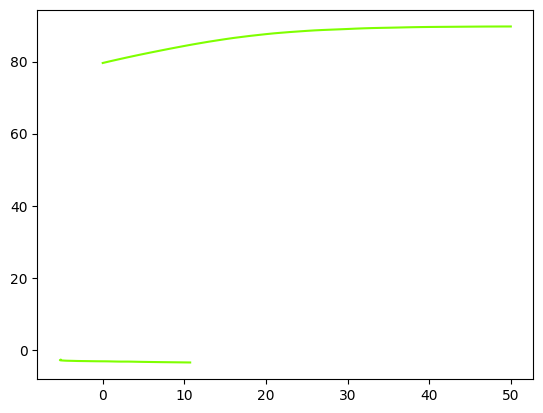

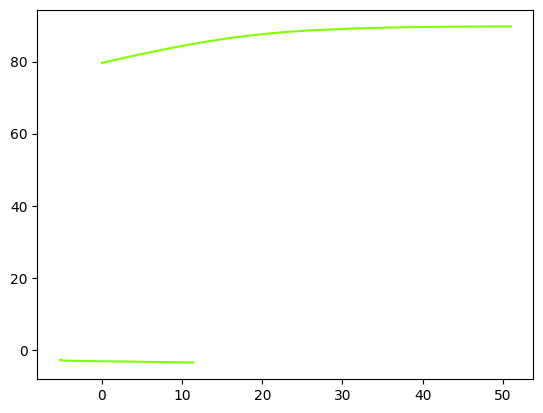

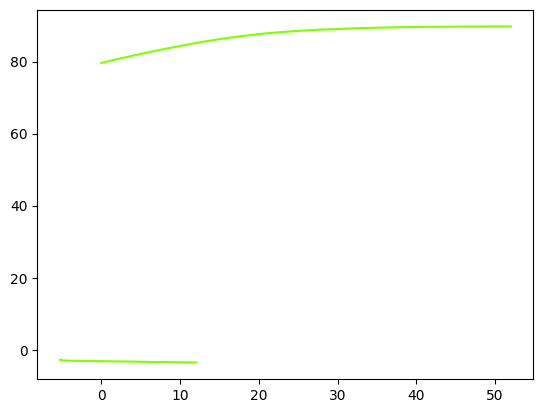

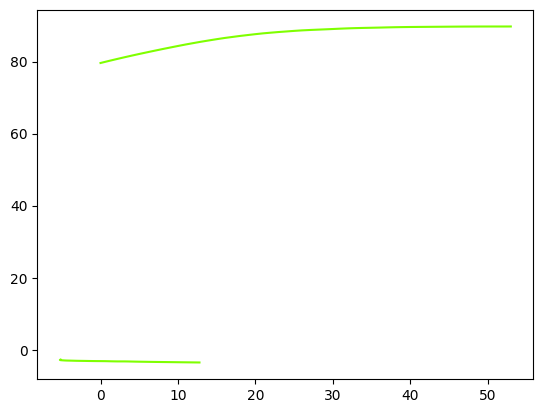

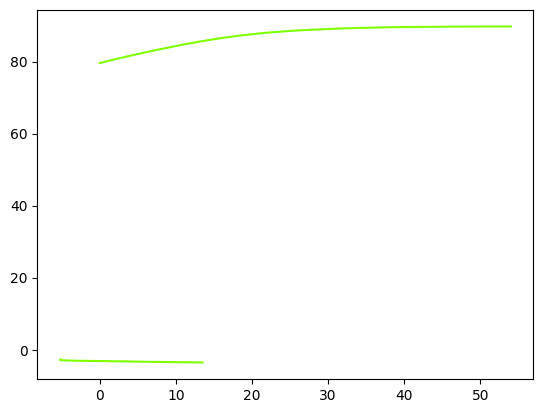

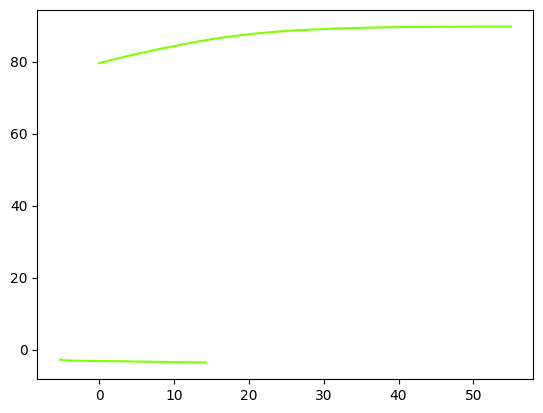

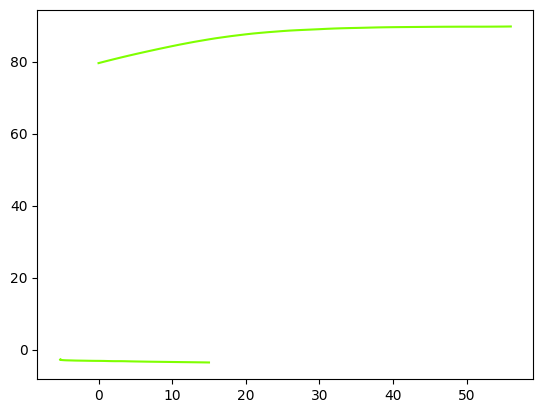

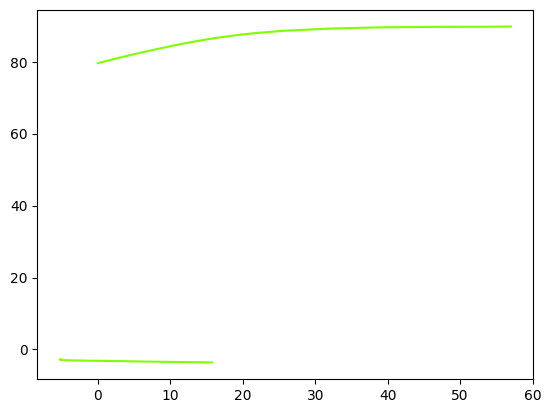

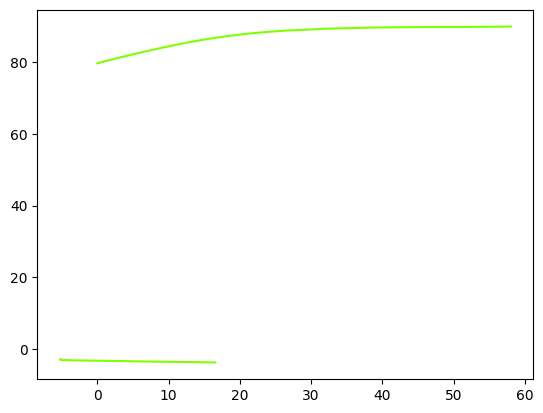

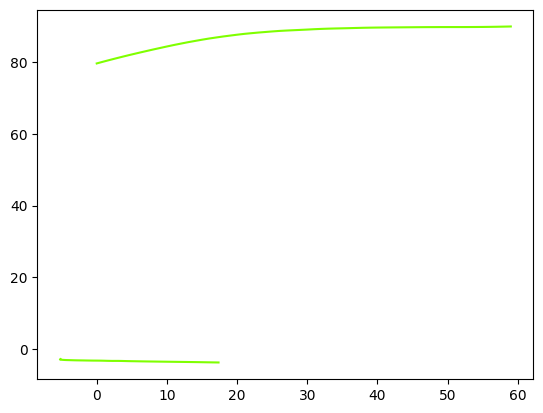

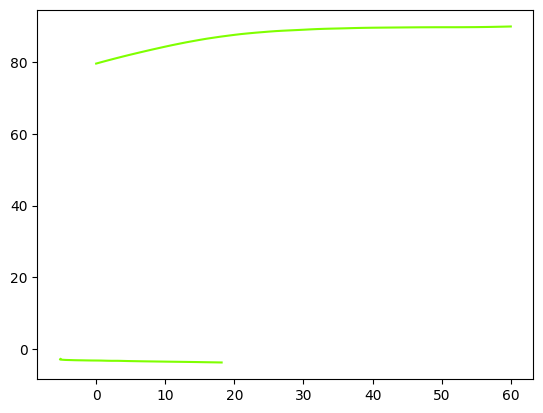

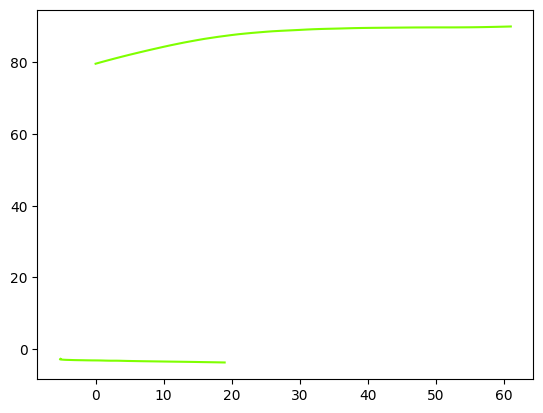

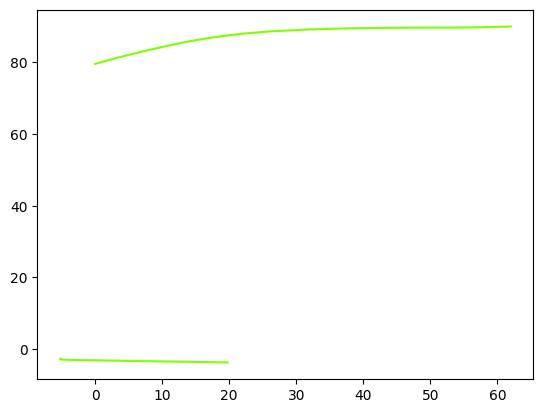

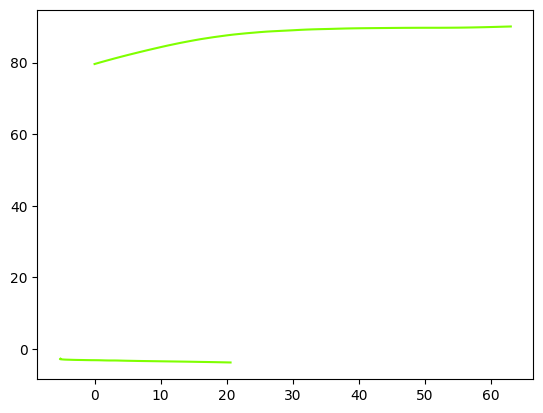

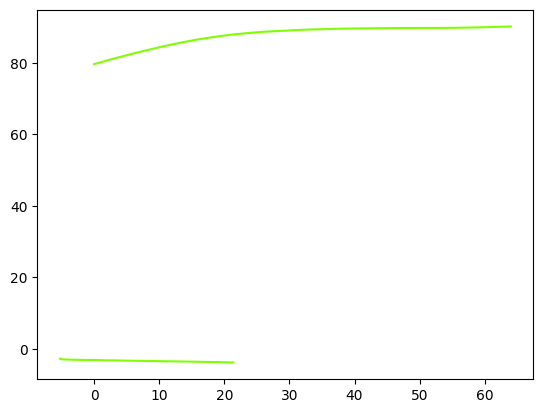

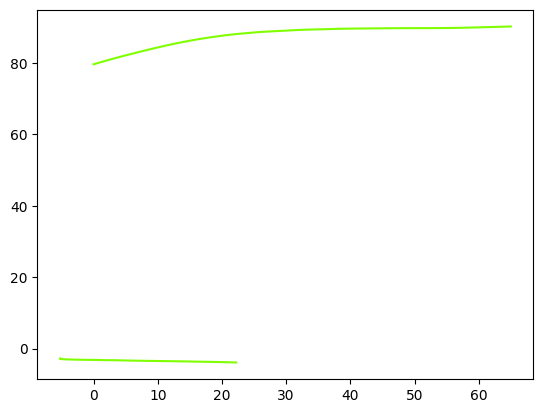

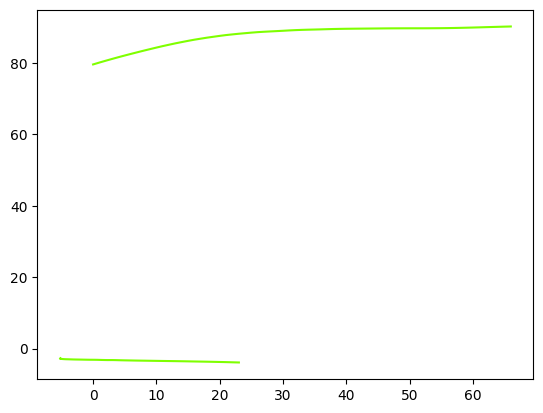

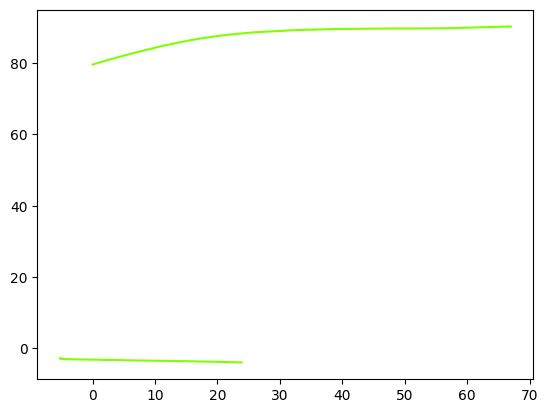

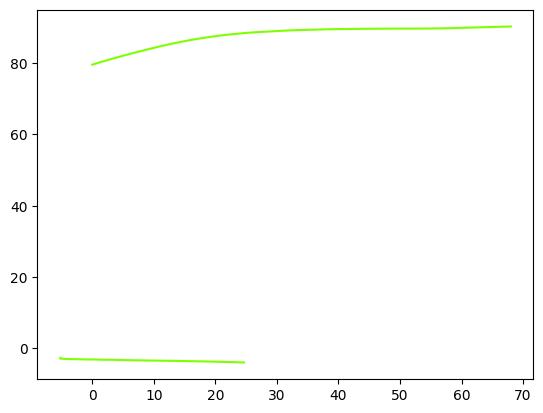

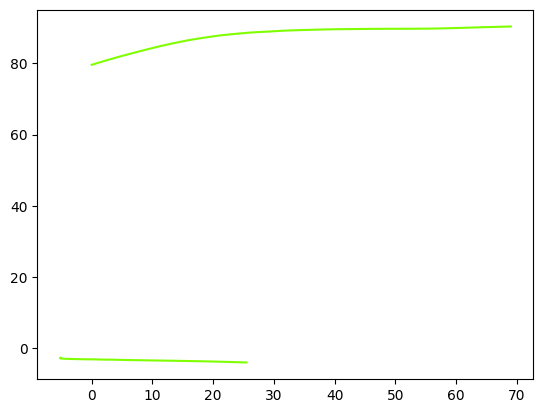

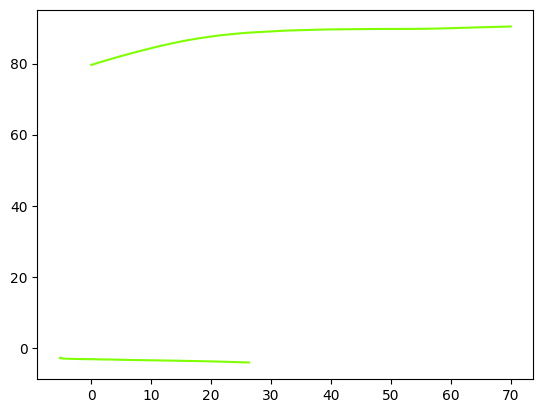

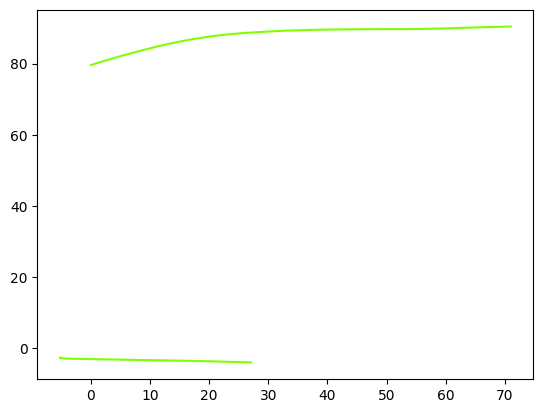

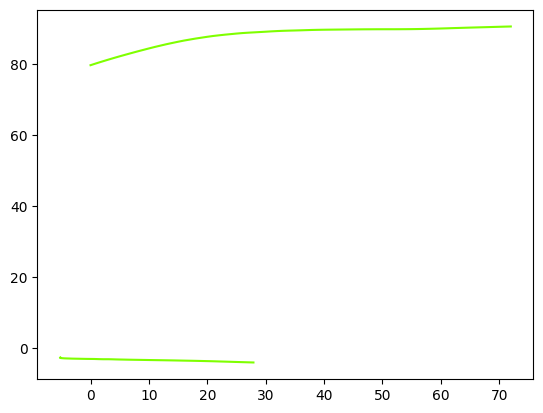

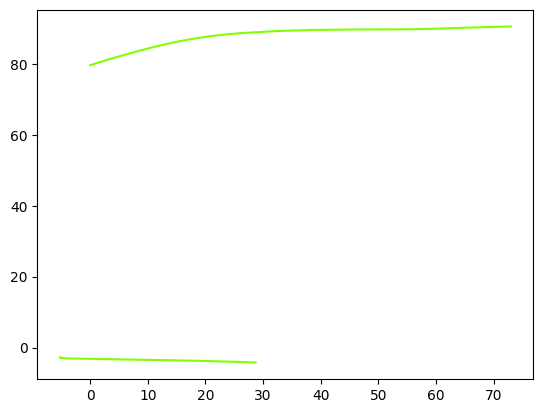

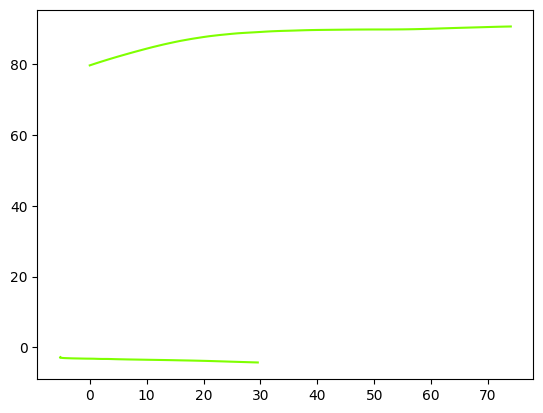

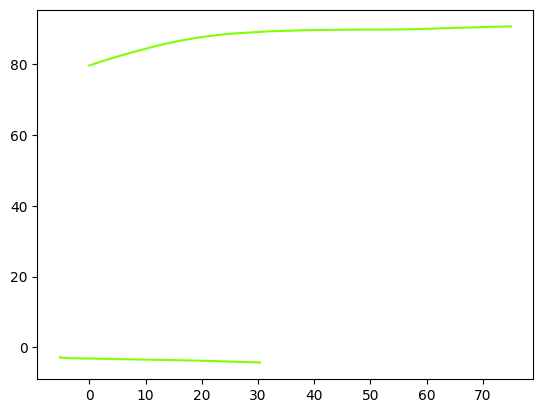

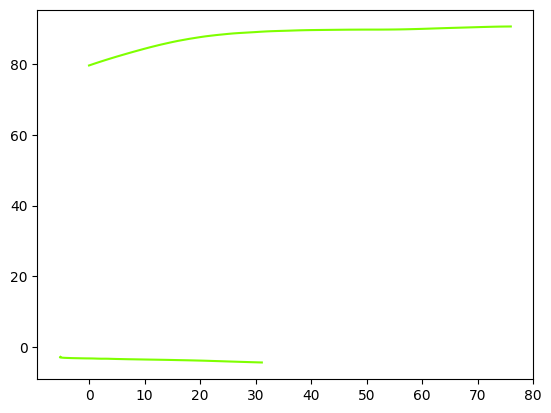

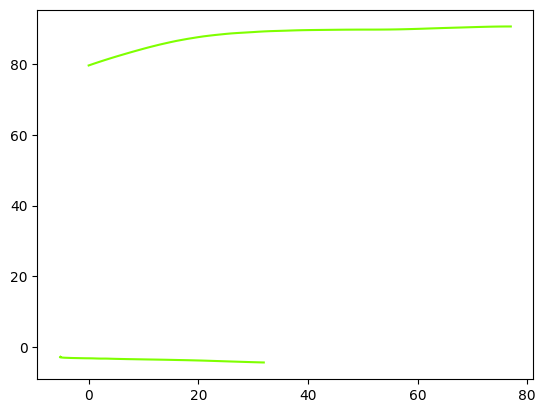

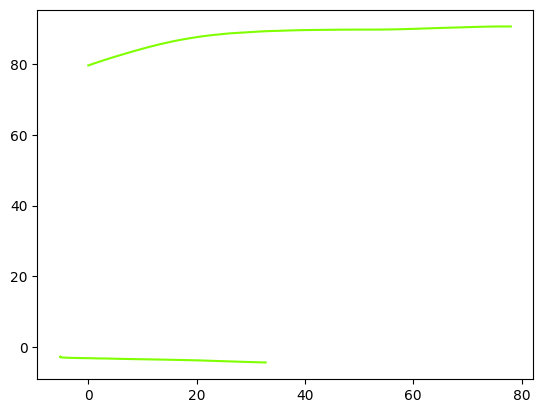

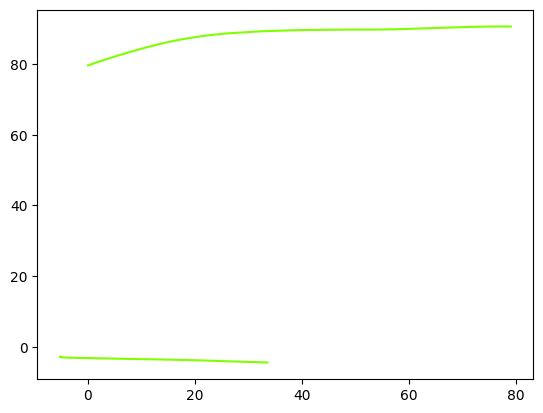

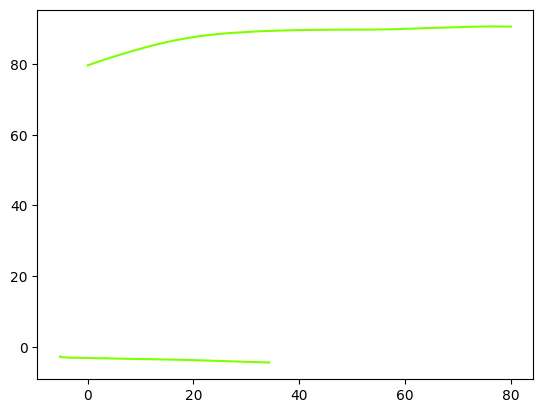

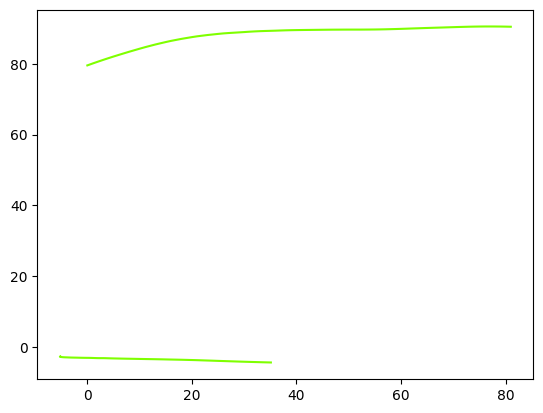

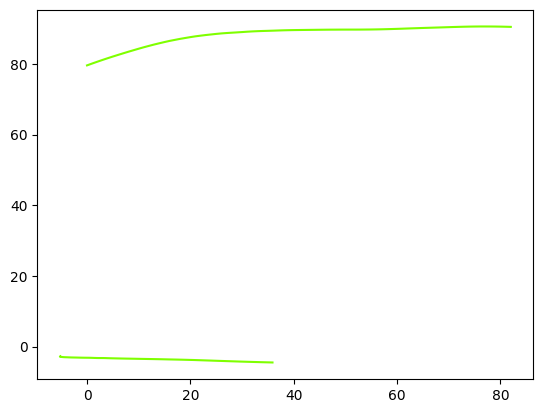

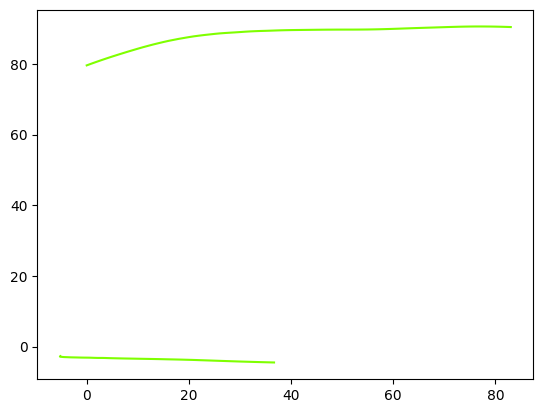

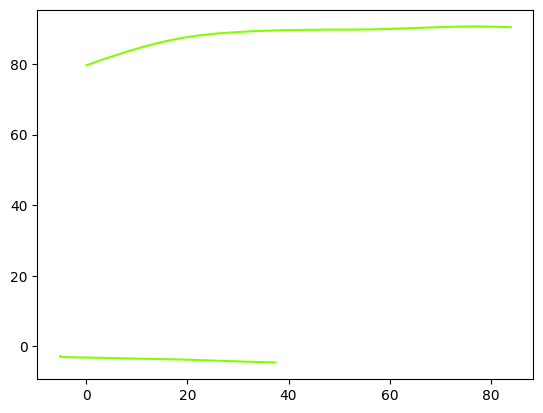

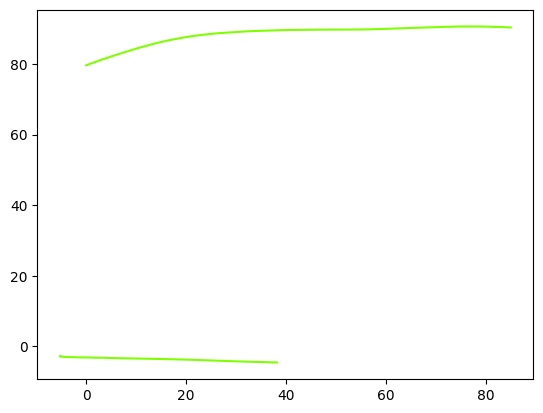

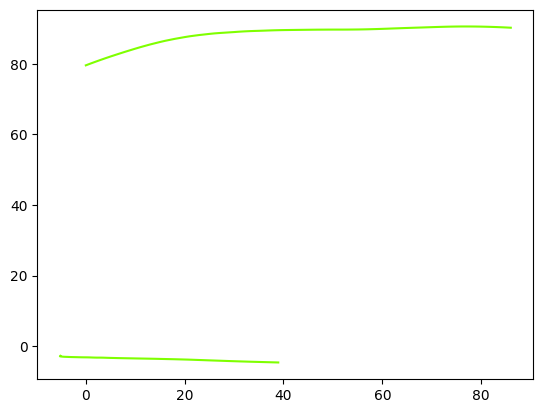

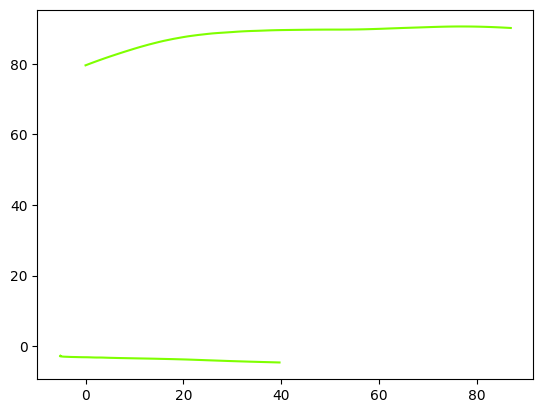

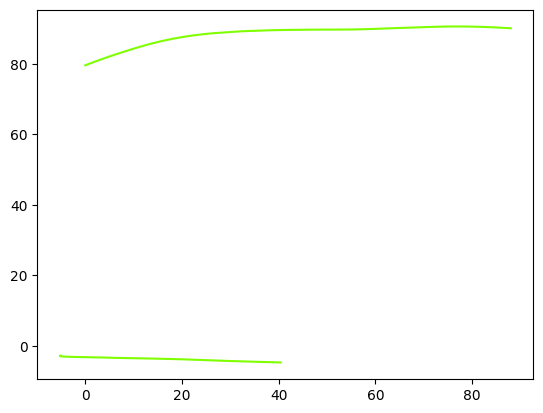

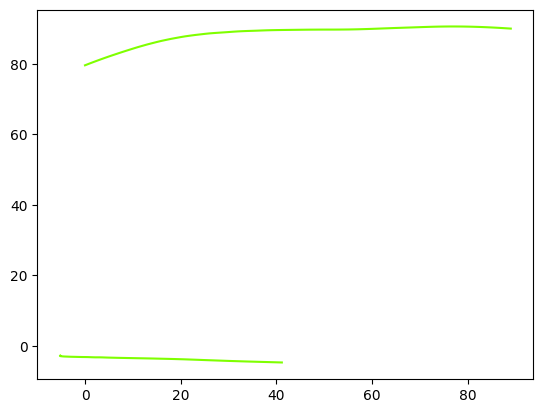

In [235]:
xs = []
ys = []
zs = []
compute_times = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-20, azim=270)
ax.plot(handler.gt[:, 0, 3], handler.gt[:, 1, 3], handler.gt[:, 2, 3], c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

stereo_l = handler.images_left
stereo_r = handler.images_right

for i in range(handler.num_frames // 50):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    start = datetime.datetime.now()
    disp = compute_left_disparity_map(img_l, img_r, matcher='sgbm')
    disp /= disp.max()
    #disp = 1 - disp
    disp = (disp*255).astype('uint8')
    #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = next(pcloud_frames)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    
    gt = next(poses)
    xs.append(gt[0, 3])
    ys.append(gt[1, 3])
    zs.append(gt[2, 3])
    plt.plot(xs, ys, zs, c='chartreuse')
    plt.pause(0.000000000000000001)
    cv2.imshow('camera', img_l)
    cv2.imshow('disparity', disp)
    cv2.imshow('lidar', pcloud)
    cv2.waitKey(1)
    
    end = datetime.datetime.now()
    compute_times.append(end-start)
    
plt.close()
cv2.destroyAllWindows()

## Difference between color channels

plt.imread() : RGB \
cv2.imread() : BGR

# SIFT (Scale Invariant Feature Transform)

We want to reduce an image to a set of locally distinct points together with the description of these points. And, to find these points in another image if it is the image of the same scene with a different camera orientation.

<img src="images/sift1.png" width=500 height=500 />

These points are found out by using difference of gaussians approach, i.e. take your image and blur it using different gaussian kernels (different magnitude) then subsract these images from each other. Now we are looking for the extreme points that stand out and are the locally distinct points for that image. We also do this for different scales of the image by using the gaussian pyramid, to make it scale invariant.

To compute the descriptor vector, we take the local neighbourhood of these points and break it down into small areas. We take gradients because they are robust with the viewpoint changes and elimination changes. Now we collect these gradients into a histogram of gradients. So now the 4\*4 region will have 16 histograms, every histogram is discritized in 45 degree orientation that is 8 bins so now we have 128 values descriptor vector.

<img src="images/sift2.png" width=900 height=500 />

[SIFT with Cyrill Stachniss](https://www.youtube.com/watch?v=4AvTMVD9ig0)

## HOG (Histogram of Gradients)

<img src="images/hog1.jpg" width=1000 height=300 />

<img src="images/hog2.jpg" width=1000 height=200 />

<img src="images/hog3.jpg" width=1000 height=300 />

We will take the features in one frame at  get their 3D coordinates and then match these features to other corresponding frames and see how the camera position has changed relatively.

In [236]:
def extract_features(image, mask=None):
    
    det = cv2.SIFT_create()      
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

k: Count of best matches found per each query descriptor or less if a query descriptor has less than k possible matches in total.

In [237]:
def match_features(des1, des2, matching='BF', sort=True, k=2):

    if matching == 'BF':
        matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [238]:
def visualize_matches(image1, kp1, image2, kp2, match):
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [239]:
def filter_matches_distance(matches, dist_threshold):
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [240]:
%matplotlib inline
handler.reset_frames()

Number of matches before filtering: 3420
Number of matches after filtering: 485


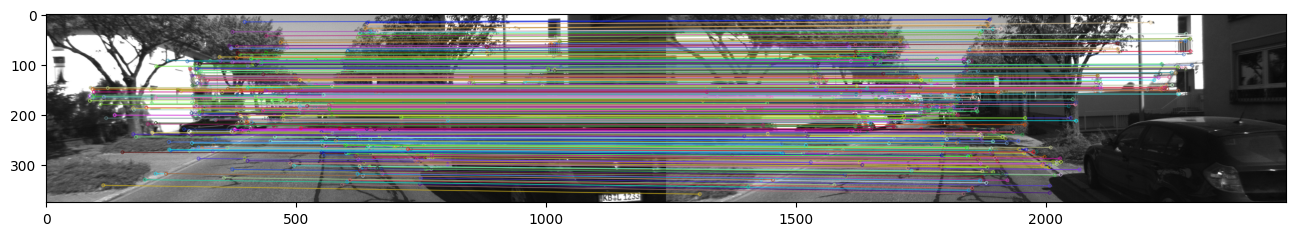

In [243]:
image_left = next(handler.images_left)
image_right = next(handler.images_right)
image_plus1 = next(handler.images_left)
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm')
kp0, des0 = extract_features(image_left)
kp1, des1 = extract_features(image_plus1)
matches = match_features(des0, des1, matching='BF', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)